In [18]:
# Import Modules
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Softmax
from keras.optimizers import Adam


In [19]:
# Global Variables
tickers =  ["AAPL", "TSLA", "AMZN", "GOOGL", "NVDA", "FB", "INTC", "AMD", "NFLX", "ADBE",
            "CSCO", "LOGI", "T", "QCOM", "FDS", "SPLK","ORCL", "VMW","NOW", "GRMN"]

# Create MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0,1))

In [10]:
def get_raw_data(tickers):
    """Downloads all the raw data history of the stocks
       and prints thier first tarding date (IPO - Initial Public Offering) 

    Parameters
    ----------
    tickers : list
        List of all the quotes' names

    Returns
    -------
    date
        The IPO of the latest quote - first common date
    """

    # Path to the folder for storing the raw data
    DATA_FOLDER_PATH = "data\\raw_data\\"

    # List for the IPOs
    ipos = []

    # Create "data\raw_data" folder if its not exist
    if not os.path.exists(DATA_FOLDER_PATH):
        os.makedirs(DATA_FOLDER_PATH)

    
    for sym in tickers:
        # Download quote history
        stk = yf.Ticker(sym)
        hist = stk.history(period="max")

        # Save it as .pikle file
        hist.to_pickle(DATA_FOLDER_PATH + sym + '_raw.pickle')

        # Add the quote's IPO date to the list
        ipo_date = hist.index[0].date()
        ipos.append(ipo_date)

        # print(sym)
        # print(ipo_date)

    return max(ipos)

last_ipo = get_raw_data(tickers)


In [11]:
def filter_data(initial_date, tickers):
    """Saves a filtered copy of the files from "raw_data" directory 

    Parameters
    ----------
    initial_date : pd.Timestamp
        Date to save the data from 
    
    tickers : list
        List of all the quotes' names
    """
    # Path to the source and the destination
    SRC_FOLDER_PATH = "data\\raw_data\\"
    DST_FOLDER_PATH = "data\\filtered_data\\"

    # Create "data\filtered_data" folder if its not exist
    if not os.path.exists(DST_FOLDER_PATH):
        os.makedirs(DST_FOLDER_PATH)

    for sym in tickers:
        # Open the raw data file
        df = pd.read_pickle(SRC_FOLDER_PATH + sym + "_raw.pickle")
        # Select only the dates that are after the first common date 
        after_ipo = df.index > initial_date
        # Keep only those rows
        df = df.loc[after_ipo]
        # Keep only "Open" & "Close" columns
        df = df.loc[:, ["Open", "Close", "High", "Low"]]
        # Save as .pickle file 
        df.to_pickle(DST_FOLDER_PATH + sym + '_filtered.pickle')

filter_data(pd.Timestamp(last_ipo), tickers)


In [103]:


def tag_data(tickers):
    """Saves a tagged copy of the files from "filtered_data" directory 

    Parameters
    ----------
    tickers : list
        List of all the quotes' names
    """

    # Path to the source and the destination
    SRC_FOLDER_PATH = "data\\filtered_data\\"
    DST_FOLDER_PATH = "data\\tagged_data\\"

    # Create "data\filtered_data" folder if its not exist
    if not os.path.exists(DST_FOLDER_PATH):
        os.makedirs(DST_FOLDER_PATH)

    for sym in tickers:
        # Open the filtered data file
        df = pd.read_pickle(SRC_FOLDER_PATH + sym + "_filtered.pickle")
        # Add a tag column
        tagged_df = add_tag_column(df)
        # Save as .pickle file 
        tagged_df.to_pickle(DST_FOLDER_PATH + sym + '_tagged.pickle')


def add_tag_column(df):
    """Add a tag column to the data frame
       Tags: ++: +5% rise between open and close
             +:  (0.5-5)% rise between open and close
             0:  (-0.5)-0.5 rise/fall between open and close
             -:  -(0.5-5)% fall between open and close
             --: -5% fall between open and close


    Parameters
    ----------
    df : pandas data frame
        Quote's filtered data 

    Returns
    -------
    df : pandas data frame
        Quote's tagged data
    """

    # Create vector of differences between open and close
    diff = df["Close"] - df["Open"]
    tag = []

    # Calculate each day tag by the change in percentage
    for change_in_price, open_price in zip(diff,df["Open"]):
        # Converet the change in dollars to percentage
        change_in_percentage = change_in_price / open_price

        # Add a tag according the rules above
        if change_in_percentage > 0.0025:
            tag.append(1)
        elif change_in_percentage < -0.0025:
            tag.append(-1)
        else:
            tag.append(0)

    '''
    # Calculate each day tag by the change in percentage
    for change_in_price, open_price in zip(diff,df["Open"]):
        # Converet the change in dollars to percentage
        change_in_percentage = change_in_price / open_price

        # Add a tag according the rules above
        if change_in_percentage >= 0.05:
            tag.append("++")
        elif change_in_percentage >= 0.005:
            tag.append("+")
        elif change_in_percentage > -0.005:
            tag.append("0")
        elif change_in_percentage > -0.05:
            tag.append("-")
        else:
            tag.append("--")
    '''
    # Add the tags column to the df
    df["Tag"] = tag
    return df

tag_data(tickers)



In [104]:
def scale(tickers):
    """Saves a scaled copy of the files from "tagged_data" directory 

    Parameters
    ----------
    tickers : list
        List of all the quotes' names
    """
    SRC_FOLDER_PATH = "data\\tagged_data\\"
    DST_FOLDER_PATH = "data\\scaled_data\\"

    # Create "data\scaled_data" folder if its not exist
    if not os.path.exists(DST_FOLDER_PATH):
        os.makedirs(DST_FOLDER_PATH)

    for sym in tickers:
        # Open the tagged data file
        df = pd.read_pickle(SRC_FOLDER_PATH + sym + "_tagged.pickle")
        # Scale the "Open" & "Close" columns
        df[["Open", "Close", "High", "Low"]] = scaler.fit_transform(df[["Open", "Close", "High", "Low"]])
        # Save as .pickle file 
        df.to_pickle(DST_FOLDER_PATH + sym + '_scaled.pickle')

scale(tickers)

In [20]:


def load_data(tickers, n, scaled=True):
    source_folder_path = "data\\scaled_data\\" if scaled else "data\\tagged_data\\"
    file_extension = "_scaled.pickle" if scaled else "_tagged.pickle"

    for sym in tickers:
        # Load the quote's data
        df = pd.read_pickle(source_folder_path + sym + file_extension)
    pass

def to_n_gram(df, n=60):
    training_data_len = math.ceil(len(df) * 0.8)
    data = df[["Open", "Close", "High", "Low"]]
    tag = df["Tag"]

    

    x_train = []
    y_train = []
    x_test = []
    y_test = tag[training_data_len-n:]

    for i in range(n, training_data_len):
        x_train.append(data.iloc[(i-n):i])
        y_train.append(tag.iloc[i])

    for i in range(training_data_len - n, len(df)):
        x_test.append(data.iloc[(i-n):i])

    #print(x_train)
    #print(y_train)
    
    return x_train, y_train, x_test, y_test

x_train, y_train, x_test, y_test = to_n_gram(pd.read_pickle("data\\scaled_data\\AAPL_scaled.pickle"), 10)

print(pd.read_pickle("data\\scaled_data\\AAPL_scaled.pickle"))
    

                Open     Close      High       Low  Tag
Date                                                   
2012-07-02  0.044767  0.046166  0.043675  0.045932    1
2012-07-03  0.047145  0.047787  0.045193  0.048410    0
2012-07-05  0.048477  0.050265  0.048524  0.049756    1
2012-07-06  0.050007  0.049309  0.047154  0.050216    0
2012-07-09  0.049587  0.051194  0.048422  0.050818    1
...              ...       ...       ...       ...  ...
2021-02-11  0.942976  0.940221  0.935925  0.942781    0
2021-02-12  0.931169  0.942057  0.929429  0.942162    0
2021-02-16  0.939853  0.925384  0.933055  0.935193   -1
2021-02-17  0.907554  0.907412  0.904429  0.909484    0
2021-02-18  0.891938  0.887762  0.885245  0.899881    0

[2172 rows x 5 columns]


In [21]:

x_train, y_train, x_test, y_test = np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1728, 10, 4)
(1728,)
(444, 10, 4)
(444,)


In [6]:
#x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2], 1))
#print(x_train)
#x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1]*x_test.shape[2], 1))
print(x_train.shape)
print(x_test.shape)

(1728, 10, 4)
(444, 10, 4)


In [22]:
'''
def one_hot(Y):
    result = np.zeros((Y.shape[0],5))
    for i in range(Y.shape[0]):
        if Y[i] == "++":
            result[i,0] = 1
        elif Y[i] == "+":
            result[i,1] = 1
        elif Y[i] == "0":
            result[i,2] = 1
        elif Y[i] == "-":
            result[i,3] = 1
        else:
            result[i,4] = 1
    return result
'''
def one_hot(Y):
    result = np.zeros((Y.shape[0],3))
    for i in range(Y.shape[0]):
        if int(Y[i]) == 1:
            result[i,0] = 1
        elif int(Y[i]) == 0:
            result[i,1] = 1
        else:
            result[i,2] = 1
    return result

y_train, y_test = one_hot(y_train), one_hot(y_test)

In [23]:

# Build the model
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
# model.add(Dense(5))
model.add(Dense(3))
model.add(Softmax())

In [24]:
# Compile the model
optimizer = Adam(lr=0.01)
model.compile(optimizer=optimizer, loss='categorical_crossentropy')

In [28]:
df = pd.read_pickle("data\\scaled_data\\AAPL_scaled.pickle")
print(df)
print(x_train)

                Open     Close      High       Low  Tag
Date                                                   
2012-07-02  0.044767  0.046166  0.043675  0.045932    1
2012-07-03  0.047145  0.047787  0.045193  0.048410    0
2012-07-05  0.048477  0.050265  0.048524  0.049756    1
2012-07-06  0.050007  0.049309  0.047154  0.050216    0
2012-07-09  0.049587  0.051194  0.048422  0.050818    1
...              ...       ...       ...       ...  ...
2021-02-11  0.942976  0.940221  0.935925  0.942781    0
2021-02-12  0.931169  0.942057  0.929429  0.942162    0
2021-02-16  0.939853  0.925384  0.933055  0.935193   -1
2021-02-17  0.907554  0.907412  0.904429  0.909484    0
2021-02-18  0.891938  0.887762  0.885245  0.899881    0

[2172 rows x 5 columns]
[[[0.04476697 0.04616632 0.04367529 0.04593241]
  [0.04714549 0.04778731 0.04519251 0.04840986]
  [0.04847657 0.05026475 0.04852443 0.04975582]
  ...
  [0.04840156 0.04766733 0.04599876 0.04809541]
  [0.04903668 0.04909547 0.04686314 0.04983922]
 

In [29]:
print(y_train)
print(y_test)


[[0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [26]:
# Train the model with the training set
model.fit(x_train, y_train, epochs=20, shuffle=False, use_multiprocessing=True)

Epoch 1/20
54/54 [==============================] - 4s 11ms/step - loss: 0.9820
Epoch 2/20
54/54 [==============================] - 1s 10ms/step - loss: 0.9558
Epoch 3/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9710
Epoch 4/20
54/54 [==============================] - 1s 10ms/step - loss: 0.9656
Epoch 5/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9628
Epoch 6/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9728
Epoch 7/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9730
Epoch 8/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9710
Epoch 9/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9697
Epoch 10/20
54/54 [==============================] - 1s 10ms/step - loss: 0.9687
Epoch 11/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9680
Epoch 12/20
54/54 [==============================] - 1s 11ms/step - loss: 0.9672
Epoch 13/20
54/54 [==================

In [13]:
predictions = model.predict(x_test)
print(predictions)


[[0.14559256 0.71451616 0.13989125]
 [0.1455861  0.7145174  0.13989651]
 [0.14549813 0.7146831  0.13981879]
 ...
 [0.1602655  0.6893976  0.15033697]
 [0.16022909 0.689455   0.1503159 ]
 [0.16000913 0.689854   0.15013681]]


In [14]:
print(np.argmax(predictions, axis=1))
print("\n")
print(np.argmax(y_test, axis=1))

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


[1 0 1 1 2 1 1 1 1 1 1 2 0 1 0 0 1 1 1 1 1 1 0 1 1 1 1 2 0 1 1 1 1 1 1 1 0
 1 1 1 1 1 1 1 2 0 1 1

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test, axis=1), np.argmax(predictions, axis=1))

array([[  0, 119,   0],
       [  0, 241,   0],
       [  0,  84,   0]], dtype=int64)

In [24]:
prdict_train = model.predict(x_train)
print(np.argmax(prdict_train, axis=1))
print("\n")
print(np.argmax(y_train, axis=1))

[2 2 2 ... 2 2 2]


[3 2 2 ... 2 1 2]


In [15]:
predictions = model.predict(x_test)
rounded = np.round(predictions)
cnt = 0
err_cnt = 0
for y, r, p in zip(y_test, rounded, predictions):
    cnt += 1
    print(f'{y}-{r}-{p}')
    if y != r:
        err_cnt += 1
print(f'{err_cnt} errors from {cnt} tests')
predictions
#predictions = scaler.inverse_transform(predictions)

2-[2.]-[2.0102098]
2-[2.]-[2.0075865]
2-[2.]-[2.0047383]
3-[2.]-[2.0011673]
1-[2.]-[1.9965138]
1-[2.]-[1.9909911]
2-[2.]-[1.9866377]
1-[2.]-[1.9842538]
2-[2.]-[1.9826714]
1-[2.]-[1.9821163]
3-[2.]-[1.9809036]
2-[2.]-[1.9796504]
3-[2.]-[1.9772564]
2-[2.]-[1.9749453]
1-[2.]-[1.9733315]
2-[2.]-[1.971051]
3-[2.]-[1.9696164]
3-[2.]-[1.9687939]
1-[2.]-[1.9675759]
3-[2.]-[1.9667232]
1-[2.]-[1.9682729]
1-[2.]-[1.9704145]
2-[2.]-[1.9738328]
2-[2.]-[1.9785229]
2-[2.]-[1.9831501]
2-[2.]-[1.9865057]
1-[2.]-[1.9891783]
1-[2.]-[1.9900626]
1-[2.]-[1.9899863]
3-[2.]-[1.9902937]
2-[2.]-[1.991969]
2-[2.]-[1.9939052]
2-[2.]-[1.9959267]
3-[2.]-[1.9971498]
1-[2.]-[1.9971378]
2-[2.]-[1.9966149]
2-[2.]-[1.9967103]
3-[2.]-[1.9969372]
1-[2.]-[1.9977878]
1-[2.]-[1.9992188]
2-[2.]-[2.000628]
2-[2.]-[2.001971]
1-[2.]-[2.0028226]
1-[2.]-[2.0019321]
3-[2.]-[2.001535]
2-[2.]-[2.0014076]
1-[2.]-[2.0013802]
2-[2.]-[2.0024781]
2-[2.]-[2.003771]
1-[2.]-[2.0043192]
3-[2.]-[2.004737]
1-[2.]-[2.0052786]
2-[2.]-[2.0051525]


array([[2.0102098],
       [2.0075865],
       [2.0047383],
       [2.0011673],
       [1.9965138],
       [1.9909911],
       [1.9866377],
       [1.9842538],
       [1.9826714],
       [1.9821163],
       [1.9809036],
       [1.9796504],
       [1.9772564],
       [1.9749453],
       [1.9733315],
       [1.971051 ],
       [1.9696164],
       [1.9687939],
       [1.9675759],
       [1.9667232],
       [1.9682729],
       [1.9704145],
       [1.9738328],
       [1.9785229],
       [1.9831501],
       [1.9865057],
       [1.9891783],
       [1.9900626],
       [1.9899863],
       [1.9902937],
       [1.991969 ],
       [1.9939052],
       [1.9959267],
       [1.9971498],
       [1.9971378],
       [1.9966149],
       [1.9967103],
       [1.9969372],
       [1.9977878],
       [1.9992188],
       [2.000628 ],
       [2.001971 ],
       [2.0028226],
       [2.0019321],
       [2.001535 ],
       [2.0014076],
       [2.0013802],
       [2.0024781],
       [2.003771 ],
       [2.0043192],


In [ ]:
def data_to_n_gram(tickers, n):

    # Path to the source and the destination
    SRC_FOLDER_PATH = "data\\tagged_data\\"
    DST_FOLDER_PATH = f"data\\n_grams\\{n}_grams\\" 

    # Create "data\n_grams\{n}_grams" folder if its not exist
    if not os.path.exists(DST_FOLDER_PATH):
        os.makedirs(DST_FOLDER_PATH)
    pass

def convert_df_to_n_gram(df, n):
    pass

def upload_all_data():
    pass

def upload_single_quote_data(sym):
    pass






    

In [4]:


tickers =  ["AAPL", "TSLA", "AMZN", "GOOGL", "NVDA", "FB", "INTC", "AMD", "NFLX", "ADBE",
            "CSCO", "LOGI", "T", "QCOM", "FDS", "SPLK","ORCL", "VMW","NOW", "GRMN"]
            
for sym in tickers:
    df = pd.read_pickle(f"data\\raw_data\\{sym}_raw.pickle")
    print(f"______________{sym}______________")
    print(df)

      ...        ...       ...        ...   
2021-01-22  58.849998  59.619999  56.650002  56.660000  85563000        0.0   
2021-01-25  56.380001  56.500000  54.060001  55.439999  61968500        0.0   
2021-01-26  55.279999  56.200001  54.849998  55.209999  31485900        0.0   
2021-01-27  54.610001  54.849998  53.299999  53.590000  49722900        0.0   
2021-01-28  54.790001  57.400002  54.700001  56.070000  49162200        0.0   

            Stock Splits  
Date                      
1980-03-17           0.0  
1980-03-18           0.0  
1980-03-19           0.0  
1980-03-20           0.0  
1980-03-21           0.0  
...                  ...  
2021-01-22           0.0  
2021-01-25           0.0  
2021-01-26           0.0  
2021-01-27           0.0  
2021-01-28           0.0  

[10306 rows x 7 columns]
______________AMD______________
                 Open       High        Low      Close    Volume  Dividends  \
Date                                                                   

In [8]:
for sym in tickers:
    df = pd.read_pickle(f"data\\filtered_data\\{sym}_filtered.pickle")
    print(f"______________{sym}______________")
    print(df)

______________AAPL______________
                  Open       Close        High         Low
Date                                                      
2012-07-02   17.988041   18.227684   18.256908   17.953278
2012-07-03   18.300280   18.439636   18.457787   18.273210
2012-07-05   18.475017   18.763575   18.898932   18.447023
2012-07-06   18.675894   18.638670   18.717423   18.506390
2012-07-09   18.620834   18.885088   18.885395   18.584226
...                ...         ...         ...         ...
2021-02-11  135.899994  135.130005  136.389999  133.770004
2021-02-12  134.350006  135.369995  135.529999  133.690002
2021-02-16  135.490005  133.190002  136.009995  132.789993
2021-02-17  131.250000  130.839996  132.220001  129.470001
2021-02-18  129.199997  128.270706  129.679993  128.229996

[2172 rows x 4 columns]
______________TSLA______________
                  Open       Close        High         Low
Date                                                      
2012-07-02    6.270000  

In [5]:
for sym in tickers:
    df = pd.read_pickle(f"data\\tagged_data\\{sym}_tagged.pickle")
    print(f"______________{sym}______________")
    print(df)

______________AAPL______________
                  Open       Close        High         Low  Tag
Date                                                           
2012-07-02   17.988041   18.227684   18.256908   17.953278    1
2012-07-03   18.300280   18.439636   18.457787   18.273210    0
2012-07-05   18.475017   18.763575   18.898932   18.447023    1
2012-07-06   18.675894   18.638670   18.717423   18.506390    0
2012-07-09   18.620834   18.885088   18.885395   18.584226    1
...                ...         ...         ...         ...  ...
2021-02-11  135.899994  135.130005  136.389999  133.770004    0
2021-02-12  134.350006  135.369995  135.529999  133.690002    0
2021-02-16  135.490005  133.190002  136.009995  132.789993   -1
2021-02-17  131.250000  130.839996  132.220001  129.470001    0
2021-02-18  129.199997  128.270706  129.679993  128.229996    0

[2172 rows x 5 columns]
______________TSLA______________
                  Open       Close        High         Low  Tag
Date         

In [17]:
for sym in tickers:
    df = pd.read_pickle(f"data\\scaled_data\\{sym}_scaled.pickle")
    print(f"______________{sym}______________")
    print(df)

______________AAPL______________
                Open     Close      High       Low  Tag
Date                                                   
2012-07-02  0.044767  0.046166  0.043675  0.045932    1
2012-07-03  0.047145  0.047787  0.045193  0.048410    0
2012-07-05  0.048477  0.050265  0.048524  0.049756    1
2012-07-06  0.050007  0.049309  0.047154  0.050216    0
2012-07-09  0.049587  0.051194  0.048422  0.050818    1
...              ...       ...       ...       ...  ...
2021-02-11  0.942976  0.940221  0.935925  0.942781    0
2021-02-12  0.931169  0.942057  0.929429  0.942162    0
2021-02-16  0.939853  0.925384  0.933055  0.935193   -1
2021-02-17  0.907554  0.907412  0.904429  0.909484    0
2021-02-18  0.891938  0.887762  0.885245  0.899881    0

[2172 rows x 5 columns]
______________TSLA______________
                Open     Close      High       Low  Tag
Date                                                   
2012-07-02  0.001018  0.000980  0.001106  0.001078   -1
2012-07-03  0

In [131]:
AAPL = pd.read_pickle(f"data\\scaled_data\\AAPL_scaled.pickle")
print(AAPL)

                Open     Close      High       Low  Tag
Date                                                   
2012-07-02  0.044767  0.046166  0.043675  0.045932    1
2012-07-03  0.047145  0.047787  0.045193  0.048410    1
2012-07-05  0.048477  0.050265  0.048524  0.049756    1
2012-07-06  0.050007  0.049309  0.047154  0.050216    0
2012-07-09  0.049587  0.051194  0.048422  0.050818    1
...              ...       ...       ...       ...  ...
2021-02-11  0.942976  0.940221  0.935925  0.942781   -1
2021-02-12  0.931169  0.942057  0.929429  0.942162    1
2021-02-16  0.939853  0.925384  0.933055  0.935193   -1
2021-02-17  0.907554  0.907412  0.904429  0.909484   -1
2021-02-18  0.891938  0.887762  0.885245  0.899881   -1

[2172 rows x 5 columns]


In [134]:
AAPL = AAPL.drop(["High", "Low"], axis=1)
AAPL

,Open,Close,Tag
Date,,,
2012-07-02,0.044767,0.046166,1
2012-07-03,0.047145,0.047787,1
2012-07-05,0.048477,0.050265,1
2012-07-06,0.050007,0.049309,0
2012-07-09,0.049587,0.051194,1
...,...,...,...
2021-02-11,0.942976,0.940221,-1
2021-02-12,0.931169,0.942057,1
2021-02-16,0.939853,0.925384,-1


In [132]:
# Count how many samples are for each tag
print(AAPL["Tag"].value_counts())
# Set df index to int instead of time stamps
appl_df = AAPL.reset_index()
appl_df

 1    913
-1    814
 0    445
Name: Tag, dtype: int64


,Date,Open,Close,High,Low,Tag
0,2012-07-02,0.044767,0.046166,0.043675,0.045932,1
1,2012-07-03,0.047145,0.047787,0.045193,0.048410,1
2,2012-07-05,0.048477,0.050265,0.048524,0.049756,1
3,2012-07-06,0.050007,0.049309,0.047154,0.050216,0
4,2012-07-09,0.049587,0.051194,0.048422,0.050818,1
...,...,...,...,...,...,...
2167,2021-02-11,0.942976,0.940221,0.935925,0.942781,-1
2168,2021-02-12,0.931169,0.942057,0.929429,0.942162,1
2169,2021-02-16,0.939853,0.925384,0.933055,0.935193,-1
2170,2021-02-17,0.907554,0.907412,0.904429,0.909484,-1


In [133]:
# Reduce vectors using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(appl_df[["Open", "Close", "High", "Low"]])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, appl_df[['Tag']]], axis = 1)


In [109]:
finalDf

,PC1,PC2,Tag
0,-0.329261,-0.000945,1
1,-0.325265,-0.000688,1
2,-0.321019,-0.000945,1
3,-0.321192,0.000246,0
4,-0.319520,-0.001107,1
...,...,...,...
2167,1.461408,0.002068,-1
2168,1.452872,-0.008470,1
2169,1.447194,0.010882,-1
2170,1.394901,0.000707,-1


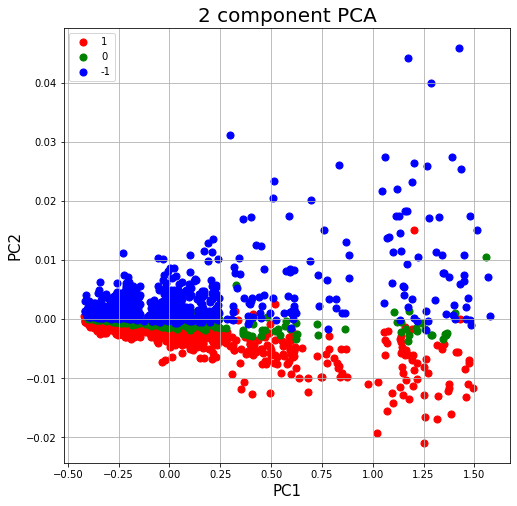

In [110]:
# Plot the data
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0, -1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Tag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [111]:
# Check the distribution of the data over the percentiles
appl_describe_df = appl_df.describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.1,0.8,0.9,0.95,0.96,0.97,0.98,0.99])
appl_describe_df

,Open,Close,High,Low,Tag
count,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000
mean,0.209793,0.210129,0.208430,0.210714,0.045580
std,0.210019,0.210821,0.211078,0.210276,0.890734
min,0.000000,0.000000,0.000000,0.000000,-1.000000
1%,0.008269,0.007700,0.006517,0.008350,-1.000000
2%,0.010566,0.009546,0.008423,0.010142,-1.000000
3%,0.012113,0.011776,0.010563,0.011803,-1.000000
4%,0.014377,0.013519,0.012563,0.013803,-1.000000
5%,0.016190,0.015384,0.014249,0.016016,-1.000000
10%,0.032480,0.031764,0.030901,0.031966,-1.000000


In [135]:
#max_threshold = appl_describe_df.loc["90%", ["Open", "Close", "High", "Low"]]
max_threshold = appl_describe_df.loc["90%", ["Open", "Close"]]
max_threshold.keys()

Index(['Open', 'Close'], dtype='object')

In [137]:
def max_features(row):
    for field in max_threshold.keys():
        
        row[field] = min(row[field], max_threshold[field])
    return row

appl_df_altizahen = appl_df.apply(max_features, axis=1)
appl_df_altizahen

,Date,Open,Close,High,Low,Tag
0,2012-07-02,0.044767,0.046166,0.043675,0.045932,1
1,2012-07-03,0.047145,0.047787,0.045193,0.048410,1
2,2012-07-05,0.048477,0.050265,0.048524,0.049756,1
3,2012-07-06,0.050007,0.049309,0.047154,0.050216,0
4,2012-07-09,0.049587,0.051194,0.048422,0.050818,1
...,...,...,...,...,...,...
2167,2021-02-11,0.495627,0.496685,0.935925,0.942781,-1
2168,2021-02-12,0.495627,0.496685,0.929429,0.942162,1
2169,2021-02-16,0.495627,0.496685,0.933055,0.935193,-1
2170,2021-02-17,0.495627,0.496685,0.904429,0.909484,-1


In [138]:
appl_df_altizahen.describe(percentiles=[0.8,0.9,0.95,0.96,0.97,0.98,0.99])

,Open,Close,High,Low,Tag
count,2172.000000,2172.000000,2172.000000,2172.000000,2172.000000
mean,0.185829,0.186073,0.208430,0.210714,0.045580
std,0.147828,0.148587,0.211078,0.210276,0.890734
min,0.000000,0.000000,0.000000,0.000000,-1.000000
50%,0.128889,0.128509,0.126676,0.129846,0.000000
80%,0.298844,0.299352,0.297436,0.301247,1.000000
90%,0.495591,0.496622,0.498215,0.498625,1.000000
95%,0.495627,0.496685,0.779251,0.777451,1.000000
96%,0.495627,0.496685,0.800587,0.799305,1.000000
97%,0.495627,0.496685,0.832308,0.827579,1.000000


In [117]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(appl_df_altizahen[["Open", "Close", "High", "Low"]])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2'])
finalDf = pd.concat([principalDf, appl_df_altizahen[['Tag']]], axis = 1)

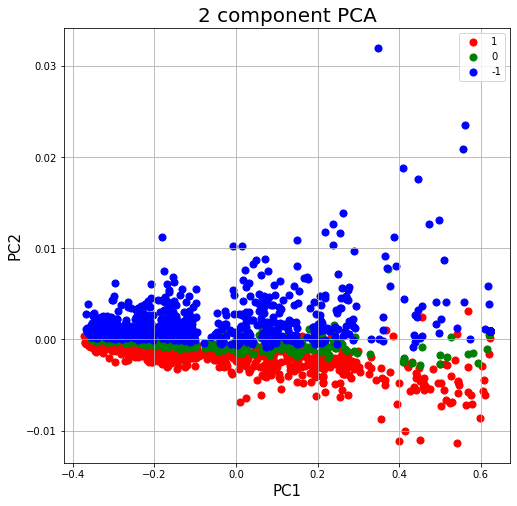

In [118]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [1, 0, -1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Tag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [119]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(appl_df_altizahen[["Open", "Close", "High", "Low"]])
principalDf = pd.DataFrame(data = principalComponents, columns = ['PC1', 'PC2', 'PC3'])
finalDf = pd.concat([principalDf, appl_df_altizahen[['Tag']]], axis = 1)


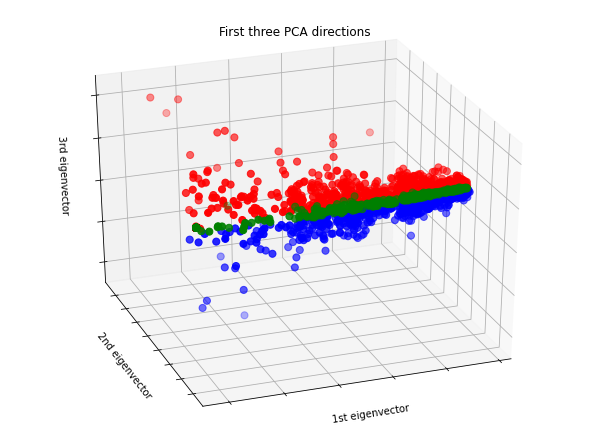

In [120]:
from mpl_toolkits.mplot3d import Axes3D

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
#ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], finalDf.loc[indicesToKeep, 'PC3'], c=finalDf['Tag'],
#           cmap=plt.cm.Set1, edgecolor='k', s=40)
targets = [1, 0, -1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Tag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC3']
               , finalDf.loc[indicesToKeep, 'PC2']
               , c = color
               , s = 50)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()


In [139]:
from sklearn import svm
from sklearn.model_selection import train_test_split

X = appl_df_altizahen.drop(['Tag', 'Date'],axis=1).values   # independant features
y = appl_df_altizahen['Tag'].values					        # dependant variable

# Choose your test size to split between training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)




In [97]:
X_train.shape

(1629, 4)

In [140]:

clf = svm.SVC()
clf.fit(X_train, y_train)
y_hat = clf.predict(X_test)

In [141]:
from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, y_hat, average='macro')


(0.263723165097952, 0.3412171997324836, 0.28327310307602177, None)

In [142]:
y_hat

array([ 1, -1,  1,  1,  1, -1,  1, -1,  1, -1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1, -1,  1,  1, -1, -1,  1,  1, -1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1, -1,  1,  1,  1, -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1, -1,
        1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1, -1,  1,  1,  1,  1, -1,  1,  1,  1, -1,  1,  1, -1, -1, -1,
       -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1, -1, -1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1,  1

In [143]:
from collections import Counter

counter = Counter(y_hat)
print(counter)

Counter({1: 412, -1: 131})


In [144]:
counter2 = Counter(y_test)
print(counter2)

Counter({1: 229, -1: 185, 0: 129})
